## Section 1: First we try PyTorch Quantization.
### This is the best available option as we will see, in terms of accuracy preservation.
### However, the FBGEMM backend is not available of FPGA and other embedded systems. In the next section we will implement Quantization from scratch

In [2]:
# import required packages
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision
from torchvision import transforms, datasets
import numpy as np
import warnings
from vgg_sym import *
from vgg_symq import *

warnings.filterwarnings('ignore')

In [3]:
# Load CIFAR-10 dataset
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
bs= 32 
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='../../../formal_pruning/dataset', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='../../../formal_pruning/dataset', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([32, 3, 32, 32])
torch.Size([32])


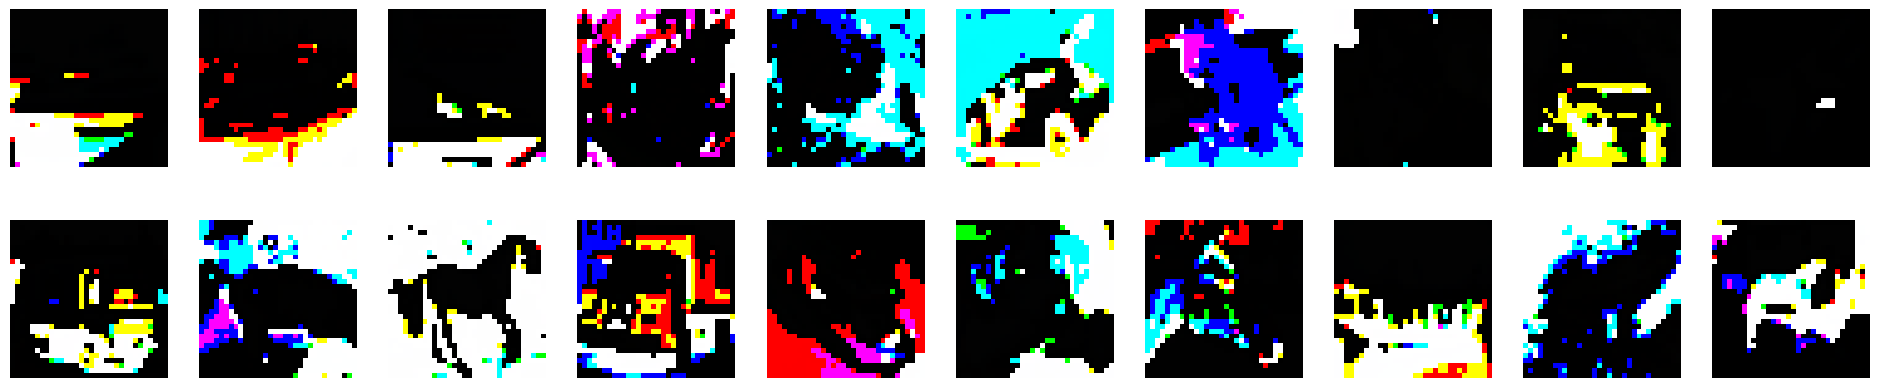

In [4]:
# Display some images

images, labels = next(iter(testloader))

print(images.shape)
print(labels.shape)

figure = plt.figure(figsize = (24,16))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0).numpy().squeeze().astype('uint8'), cmap='cool')

In [5]:
# VGG Model - Defined in vgg_sym.py 
pretrained_model = "./cifar_vgg_sym_v3.pt"
net = VGG('VGG11')
sd = torch.load(pretrained_model, map_location=torch.device('cpu'))
net.load_state_dict(sd['net'])

<All keys matched successfully>

In [7]:
# Helper function for getting the model size
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', round(os.path.getsize('temp.p')/(1024*1024),3))
    os.remove('temp.p')

In [8]:
print_size_of_model(net)

Size of the model(MB): 35.198


In [9]:
# Main accuracy testing function

def test(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()
    
    # Testing with qauntization if quantize=True
    if quantize:
#         modules_to_fuse = [['conv1', 'bn1'],
#                    ['layer1.0.conv1', 'layer1.0.bn1'],
#                    ['layer1.0.conv2', 'layer1.0.bn2'],
#                    ['layer1.1.conv1', 'layer1.1.bn1'],
#                    ['layer1.1.conv2', 'layer1.1.bn2'],
#                    ['layer2.0.conv1', 'layer2.0.bn1'],
#                    ['layer2.0.conv2', 'layer2.0.bn2'],
#                    ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
#                    ['layer2.1.conv1', 'layer2.1.bn1'],
#                    ['layer2.1.conv2', 'layer2.1.bn2'],
#                    ['layer3.0.conv1', 'layer3.0.bn1'],
#                    ['layer3.0.conv2', 'layer3.0.bn2'],
#                    ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
#                    ['layer3.1.conv1', 'layer3.1.bn1'],
#                    ['layer3.1.conv2', 'layer3.1.bn2'],
#                    ['layer4.0.conv1', 'layer4.0.bn1'],
#                    ['layer4.0.conv2', 'layer4.0.bn2'],
#                    ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
#                    ['layer4.1.conv1', 'layer4.1.bn1'],
#                    ['layer4.1.conv2', 'layer4.1.bn2']]
#         model = torch.quantization.fuse_modules(model, modules_to_fuse)
        if fbgemm:
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        else:
            model.qconfig = torch.quantization.default_qconfig
        torch.quantization.prepare(model, inplace=True)
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                model.forward(data)
            torch.quantization.convert(model, inplace=True)
            print("======= Quantization Done =====")


    print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 4)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [10]:
# Baseline performance - unquantized model
device = 'cpu'
test(model=net, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 35.198
PyTorch optimized model te

In [11]:
# Quantization Performance
# Load the model to be quantized with Pytorch Quantization
netq = VGGQ('VGG11Q')
sdq = torch.load(pretrained_model, map_location=torch.device('cpu'))
netq.load_state_dict(sdq['net'])
device = 'cpu'
test(model=netq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True)
# This performs the quantized inference. This is PyTorch static quantization. We only did activations quantization
# and performed the calibration required post training. The ACC drop is 0.19% only

======= Quantization Done =====
VGGQ(
  (features): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.303924024105072, zero_point=64)
    (1): ReLU(inplace=True)
    (2): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.3796601891517639, zero_point=61)
    (3): ReLU(inplace=True)
    (4): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.24186919629573822, zero_point=66)
    (5): ReLU(inplace=True)
    (6): QuantizedConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.200422003865242, zero_point=54)
    (7): ReLU(inplace=True)
    (8): QuantizedConv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.12747766077518463, zero_point=44)
    (9): ReLU(inplace=True)
    (10): QuantizedConv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.06178085505962372, zero_point=53)
    (11): ReLU(inplace=True)
    (12): QuantizedConv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.07090853154659271, zero_

## Section 2: From scratch post training quantization - with calibration  
### As the FBGEMM backend is not available of FPGA and other embedded systems, we implement a simple quantization from scratch. We will take this to FPGA in the FPGA implementation 

In [13]:
# Routines for post training quantization - with calibration from scratch    
    
# Simple implementation for FPGA
# Routines for Quantization    

# Routines for Quantization    
    
from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
nb = 8
def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits=nb, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale_next = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale_next
  
  zero_point_next = 0
  if initial_zero_point < qmin:
      zero_point_next = qmin
  elif initial_zero_point > qmax:
      zero_point_next = qmax
  else:
      zero_point_next = initial_zero_point

  zero_point_next = int(zero_point_next)

  return scale_next, zero_point_next
  
def quantizeLayer(x, layer, stat, scale_x, zp_x, num_bits=nb):
  # for both conv and linear layers
  W = layer.weight.data
  B = layer.bias.data

  # scale_x = x.scale
  # zp_x = x.zero_point
  w = quantize_tensor(layer.weight.data,num_bits) 
  b = quantize_tensor(layer.bias.data,num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ####################################################################
  # This is Quantisation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  scale_w = w.scale
  zp_w = w.zero_point
  
  scale_b = b.scale
  zp_b = b.zero_point
  

  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Perparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = (scale_x * scale_w/scale_next)*(layer.weight.data - zp_w)
  layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int

  #x = (layer(X)/ scale_next) + zero_point_next 
  x = layer(X) + zero_point_next   
  
  # Perform relu too
  x = F.relu(x)
    
    
  # Reset
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next


def quantForward(model, x, stats):
  #print(x.shape)
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'])
  #print(model.features[0].weight.data.shape)

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.features[0], stats['conv2'], x.scale, x.zero_point)
  #x = model.features[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[2], stats['conv3'], scale_next, zero_point_next)
  #x = model.features[3](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[4], stats['conv4'], scale_next, zero_point_next)
  #x = model.features[5](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[6], stats['conv5'], scale_next, zero_point_next)
  #x = model.features[7](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[8], stats['conv6'], scale_next, zero_point_next)
  #x = model.features[9](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[10], stats['conv7'], scale_next, zero_point_next)
  #x = model.features[11](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[12], stats['conv8'], scale_next, zero_point_next)
  #x = model.features[13](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[14], stats['fc'], scale_next, zero_point_next)
  #x = model.features[15](x)
    
  
  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512)   
  
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.classifier(x)

  return x


# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)
  
  
  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  x = model.features[1](model.features[0](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  x =  model.features[3](model.features[2](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3')
  x = model.features[5](model.features[4](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4')
  x = model.features[7](model.features[6](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5')
  x = model.features[9](model.features[8](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6')
  x = model.features[11](model.features[10](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7')
  x = model.features[13](model.features[12](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8')
  x = model.features[15](model.features[14](x))

  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512) 
  
  stats = updateStats(x, stats, 'fc')

  x = model.classifier(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return final_stats

# Routines for performance testing

def test_quant_scr(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False, stats=None):
    model.to(device)
    model.eval()
    
    print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            # Testing with qauntization if quantize=True
            if quantize:
                output = quantForward(model, X, stats)
            else:    
                output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 2)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [14]:
# Quantized model performance
# Copy from the original model for Q
import copy
netqq = copy.deepcopy(net)

# one time stats gathering - we will keep this stored for MNIST FPGA implementation
# This is doing the required calibration for finding the min, max of the activations
stats = gatherStats(netqq, trainloader)
print(stats)

{'conv1': {'max': tensor(75.4283), 'min': tensor(-77.5850)}, 'conv2': {'max': tensor(296.1228), 'min': tensor(0.)}, 'conv3': {'max': tensor(306.3843), 'min': tensor(0.)}, 'conv4': {'max': tensor(236.8686), 'min': tensor(0.)}, 'conv5': {'max': tensor(207.8151), 'min': tensor(0.)}, 'conv6': {'max': tensor(125.4137), 'min': tensor(0.)}, 'conv7': {'max': tensor(49.3179), 'min': tensor(0.)}, 'conv8': {'max': tensor(67.7475), 'min': tensor(0.)}, 'fc': {'max': tensor(91.8696), 'min': tensor(3.8462e-10)}}


In [15]:
# Quantized Inference with the normal model
test_quant_scr(model=netqq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True, stats=stats)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 35.198
PyTorch optimized model te

### What is this! Bad performance after Quantization compared to PyTorch Post training quantization with calibration. 
### We will try out Quantization Aware Re-Training now to recover the accuracy. then we take this model to FPGA

In [16]:
# Some more definitions required for the inference on the QAT model that we have trained offline

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def calcScaleZeroPointSym(min_val, max_val,num_bits=8):
  
  # Calc Scale 
  max_val = max(abs(min_val), abs(max_val))
  qmin = 0.
  qmax = 2.**(num_bits-1) - 1.

  scale = max_val / qmax

  return scale, 0

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)

def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
  # for both conv and linear layers

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # WEIGHTS SIMULATED QUANTISED

  # quantise weights, activations are already quantised
  if sym:
    w = quantize_tensor_sym(layer.weight.data,num_bits=num_bits) 
    b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
  else:
    w = quantize_tensor(layer.weight.data, num_bits=num_bits) 
    b = quantize_tensor(layer.bias.data, num_bits=num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ## END WEIGHTS QUANTISED SIMULATION


  if vis:
    axs[X,y].set_xlabel("Visualising weights of layer: ")
    visualise(layer.weight.data, axs[X,y])

  # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
  # This is Quantisation Arithmetic
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  if sym:
    scale_next, zero_point_next = calcScaleZeroPointSym(min_val=stat['min'], max_val=stat['max'])
  else:
    scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by saturating range to num_bits range.
  if sym:
    X = x.float()
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
  else:
    X = x.float() - zp_x
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data - zp_w)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int computation
  if sym:  
    x = (layer(X)) 
  else:
    x = (layer(X)) + zero_point_next 
  
  # cast to int
  x.round_()

  # Perform relu too
  x = F.relu(x)

  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next

# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)

  # add ema calculation

  if key not in stats:
    stats[key] = {'max': max_val.sum(), 'min': min_val.sum(), 'total': 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    if 'total' in stats[key]:
        stats[key]['total'] += 1
    else:
        stats[key]['total'] = 1
  
  weighting = 2.0 / (stats[key]['total']) + 1

  if 'ema_min' in stats[key]:
    stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
  else:
    stats[key]['ema_min'] = weighting*(min_val.mean().item())

  if 'ema_max' in stats[key]:
    stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
  else: 
    stats[key]['ema_max'] = weighting*(max_val.mean().item())

  stats[key]['min_val'] = stats[key]['min']/ stats[key]['total']
  stats[key]['max_val'] = stats[key]['max']/ stats[key]['total']
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  x = model.features[1](model.features[0](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  x =  model.features[3](model.features[2](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3')
  x = model.features[5](model.features[4](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4')
  x = model.features[7](model.features[6](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5')
  x = model.features[9](model.features[8](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6')
  x = model.features[11](model.features[10](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7')
  x = model.features[13](model.features[12](x))
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8')
  x = model.features[15](model.features[14](x))

  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512) 
  
  stats = updateStats(x, stats, 'fc')

  x = model.classifier(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cpu'
    
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
  X = 0
  y = 0
  # Quantise before inputting into incoming layers
  if sym:
    x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)
  else:
    x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)

    # Quantise before inputting into incoming layers
  if sym:
    x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=nb)
  else:
    x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=nb)

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.features[0], stats['conv2'], x.scale, x.zero_point)
  #x = model.features[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[2], stats['conv3'], scale_next, zero_point_next)
  #x = model.features[3](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[4], stats['conv4'], scale_next, zero_point_next)
  #x = model.features[5](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[6], stats['conv5'], scale_next, zero_point_next)
  #x = model.features[7](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[8], stats['conv6'], scale_next, zero_point_next)
  #x = model.features[9](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[10], stats['conv7'], scale_next, zero_point_next)
  #x = model.features[11](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[12], stats['conv8'], scale_next, zero_point_next)
  #x = model.features[13](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.features[14], stats['fc'], scale_next, zero_point_next)
  #x = model.features[15](x)
    
  
  #x = x.view(x.size(0), -1)  
  x = x.view(-1, 512)   
  
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.classifier(x)

  return x

import torch

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):

  #print(x.shape)
  #print(model.features[0].weight.data.shape) 
  #x = model.features[0](x)
  #x = model.features[1](x)
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  #x =  model.features[3](model.features[2](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3')
  #x = model.features[5](model.features[4](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4')
  #x = model.features[7](model.features[6](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5')
  #x = model.features[9](model.features[8](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6')
  #x = model.features[11](model.features[10](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7')
  #x = model.features[13](model.features[12](x))
  #stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8')
  #x = model.features[15](model.features[14](x))
  ##x = x.view(x.size(0), -1)  
  #x = x.view(-1, 512) 
  #stats = updateStats(x, stats, 'fc')
  #x = model.classifier(x)

  conv1weight = model.features[0].weight.data
  model.features[0].weight.data = FakeQuantOp.apply(model.features[0].weight.data, num_bits)
  x = model.features[1](model.features[0](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])

  conv2weight = model.features[2].weight.data
  model.features[2].weight.data = FakeQuantOp.apply(model.features[2].weight.data, num_bits)
  x = model.features[3](model.features[2](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv2']['ema_min'], stats['conv2']['ema_max'])

  conv3weight = model.features[4].weight.data
  model.features[4].weight.data = FakeQuantOp.apply(model.features[4].weight.data, num_bits)
  x = model.features[5](model.features[4](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv3')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv3']['ema_min'], stats['conv3']['ema_max'])


  conv4weight = model.features[6].weight.data
  model.features[6].weight.data = FakeQuantOp.apply(model.features[6].weight.data, num_bits)
  x = model.features[7](model.features[6](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv4')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv4']['ema_min'], stats['conv4']['ema_max'])


  conv5weight = model.features[8].weight.data
  model.features[8].weight.data = FakeQuantOp.apply(model.features[8].weight.data, num_bits)
  x = model.features[9](model.features[8](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv5')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv5']['ema_min'], stats['conv5']['ema_max'])



  conv6weight = model.features[10].weight.data
  model.features[10].weight.data = FakeQuantOp.apply(model.features[10].weight.data, num_bits)
  x = model.features[11](model.features[10](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv6')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv6']['ema_min'], stats['conv6']['ema_max'])


  conv7weight = model.features[12].weight.data
  model.features[12].weight.data = FakeQuantOp.apply(model.features[12].weight.data, num_bits)
  x = model.features[13](model.features[12](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv7')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv7']['ema_min'], stats['conv7']['ema_max'])


  conv8weight = model.features[14].weight.data
  model.features[14].weight.data = FakeQuantOp.apply(model.features[14].weight.data, num_bits)
  x = model.features[15](model.features[14](x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv8')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv8']['ema_min'], stats['conv8']['ema_max'])

  x = x.view(-1, 512) 
  x = model.classifier(x)

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc')


  return x, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, stats

# Training
def train(epoch, trainloader, optimizer, criterion, model, device, stats, act_quant=False, num_bits=8):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        #outputs = net(inputs)
        outputs, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, stats = quantAwareTrainingForward(model, inputs, stats, num_bits=num_bits, act_quant=act_quant)
        model.features[0].weight.data   = conv1weight
        model.features[2].weight.data   = conv2weight
        model.features[4].weight.data   = conv3weight
        model.features[6].weight.data   = conv4weight
        model.features[8].weight.data   = conv5weight
        model.features[10].weight.data  = conv6weight
        model.features[12].weight.data  = conv7weight
        model.features[14].weight.data  = conv8weight
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_qat(epoch, testloader, criterion, model, device, stats, act_quant, num_bits=8):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            #outputs = net(inputs)
            outputs, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, stats = quantAwareTrainingForward(model, inputs, stats, num_bits=num_bits, act_quant=act_quant)
            model.features[0].weight.data   = conv1weight
            model.features[2].weight.data   = conv2weight
            model.features[4].weight.data   = conv3weight
            model.features[6].weight.data   = conv4weight
            model.features[8].weight.data   = conv5weight
            model.features[10].weight.data  = conv6weight
            model.features[12].weight.data  = conv7weight
            model.features[14].weight.data  = conv8weight
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [22]:
# now we test the QAT trained model's inference accuracy
pretrained_modelqat = "./cifar_qat.pt"
netqat = VGG('VGG11')
sdqat = torch.load(pretrained_modelqat, map_location=torch.device('cpu'))
netqat.load_state_dict(sdqat['net'])
stats = gatherStats(netqat, trainloader)
print(stats) 

{'conv1': {'max': tensor(75.4060), 'min': tensor(-77.5925), 'ema_min': -2.429084955641284, 'ema_max': 2.2644749349894213}, 'conv2': {'max': tensor(289.6924), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 9.745374106466938}, 'conv3': {'max': tensor(311.6935), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 10.426215821130976}, 'conv4': {'max': tensor(234.2506), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 7.733187223847345}, 'conv5': {'max': tensor(221.5462), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 7.1292019954629575}, 'conv6': {'max': tensor(112.8982), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 3.626955604523778}, 'conv7': {'max': tensor(56.8567), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 1.961748730051182}, 'conv8': {'max': tensor(65.4364), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 2.0627339223770456}, 'fc': {'max': tensor(93.6161), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 2.7617917017409255}}


In [20]:
criterion = nn.CrossEntropyLoss()
epoch = 1
act_quant = True 
test_qat(epoch, testloader, criterion, netqat, device, stats, act_quant, num_bits=8)

0 313 Loss: 2.311 | Acc: 6.250% (2/32)
1 313 Loss: 6.531 | Acc: 9.375% (6/64)
2 313 Loss: 5.122 | Acc: 10.417% (10/96)
3 313 Loss: 3.932 | Acc: 29.688% (38/128)
4 313 Loss: 3.608 | Acc: 24.375% (39/160)
5 313 Loss: 3.094 | Acc: 34.896% (67/192)
6 313 Loss: 2.688 | Acc: 43.304% (97/224)
7 313 Loss: 2.416 | Acc: 49.609% (127/256)
8 313 Loss: 2.273 | Acc: 54.167% (156/288)
9 313 Loss: 2.085 | Acc: 58.125% (186/320)
10 313 Loss: 1.895 | Acc: 61.932% (218/352)
11 313 Loss: 1.758 | Acc: 64.323% (247/384)
12 313 Loss: 1.662 | Acc: 66.827% (278/416)
13 313 Loss: 1.597 | Acc: 68.527% (307/448)
14 313 Loss: 1.550 | Acc: 70.000% (336/480)
15 313 Loss: 1.461 | Acc: 71.680% (367/512)
16 313 Loss: 1.395 | Acc: 72.978% (397/544)
17 313 Loss: 1.351 | Acc: 73.785% (425/576)
18 313 Loss: 1.291 | Acc: 75.000% (456/608)
19 313 Loss: 1.227 | Acc: 76.250% (488/640)
20 313 Loss: 1.189 | Acc: 76.786% (516/672)
21 313 Loss: 1.174 | Acc: 77.415% (545/704)
22 313 Loss: 1.153 | Acc: 77.853% (573/736)
23 313 Loss:

181 313 Loss: 0.710 | Acc: 88.582% (5159/5824)
182 313 Loss: 0.710 | Acc: 88.576% (5187/5856)
183 313 Loss: 0.711 | Acc: 88.587% (5216/5888)
184 313 Loss: 0.712 | Acc: 88.547% (5242/5920)
185 313 Loss: 0.712 | Acc: 88.575% (5272/5952)
186 313 Loss: 0.708 | Acc: 88.636% (5304/5984)
187 313 Loss: 0.708 | Acc: 88.614% (5331/6016)
188 313 Loss: 0.711 | Acc: 88.608% (5359/6048)
189 313 Loss: 0.709 | Acc: 88.618% (5388/6080)
190 313 Loss: 0.708 | Acc: 88.645% (5418/6112)
191 313 Loss: 0.704 | Acc: 88.688% (5449/6144)
192 313 Loss: 0.706 | Acc: 88.633% (5474/6176)
193 313 Loss: 0.707 | Acc: 88.628% (5502/6208)
194 313 Loss: 0.707 | Acc: 88.654% (5532/6240)
195 313 Loss: 0.709 | Acc: 88.632% (5559/6272)
196 313 Loss: 0.706 | Acc: 88.690% (5591/6304)
197 313 Loss: 0.703 | Acc: 88.731% (5622/6336)
198 313 Loss: 0.704 | Acc: 88.725% (5650/6368)
199 313 Loss: 0.702 | Acc: 88.750% (5680/6400)
200 313 Loss: 0.704 | Acc: 88.728% (5707/6432)
201 313 Loss: 0.707 | Acc: 88.707% (5734/6464)
202 313 Loss:

###  Ah! Now we get a decent performance with both activation and weight quantization. We will take this model to FPGA

In [ ]:
# Bonus experiment - how about a 4-bit quantization?
test_qat(epoch, testloader, criterion, netqat, device, stats, act_quant, num_bits=4)

## Section 3: DietCNN Inference - Multiplication Free
### The main efficacy of this is in the FPGA implementation.

In [26]:
# Added set of imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets

# For training
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import faiss
import sys
sys.path.insert(1, '../core')
from lut_utils_cifar import *
import warnings
warnings.filterwarnings('ignore')
from patchlib import *
import multiprocessing
from joblib import Parallel, delayed
from vgg_sym import *
from eval_vgg_cifar import *
PARALLEL = 30 

In [35]:
# Test method for the DietCNN CIFAR-10 VGG Network. Stand alone Python file is also provided 
# with instrumentation functions for CIFAR-10 VGG DietCNN inference

HOWDY = 20000000 

# Test accuracy of symbolic inference
def test_fullsym_acc(model, data_iter, bss=1):
    correct = 0 
    total = 0 
    counter = 0
    model.eval()
    for data in data_iter:
        X, y = data
        if counter > HOWDY:
            break
        output = model.forward(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
            #if True:
                correct += 1
        
        counter +=bss 
        total += bss
        if(counter > 0 and counter % bss == 0):
            print("Full symbolic model test accuracy DietCNN :{}% ".format(100*round(correct/total, 4)))
    return round(correct/total, 4)

In [ ]:
# DietCNN HyperParameters - 3 main 
# 1. Image  and all activation symbols 
# 2 & 3. Symbols for CONV and FC layers dictionary 
bs=4
index = faiss.read_index("./kmeans_vgg11_fullnet_cifar10_k1_512_v0.index")
#index = faiss.read_index("./kmeans_vgg11_fullnet_cifar10_k1_256_v0.index")
#index = faiss.read_index("./kmeans_vgg11_fullnet_cifar10_k1_64_v0.index")
n_clusters=512

# using a single pixel patch as of now
conv_patch_size = (1, 1)
patch_size = (1, 1)
all_patch_size = (1, 1)
patch_stride = 1
# Hyperparameters 2 & 3. Symbols for CONV and FC layers dictionary 
n_cluster_conv_filters = 256
n_cluster_fc_filters = 128
conv_stride = 1

# this is the reverse dictionary - symbol to patch 
centroid_lut = index.reconstruct_n(0, n_clusters)

import pickle
# Load the CONV and FC dictionaries and the LUT that are created already
with open('cifar10_conv_flt.index', "rb") as f:
    filter_index_conv = pickle.load(f)
with open('cifar10_fc_flt.index', "rb") as f:
    filter_index_fc = pickle.load(f)
fc_lut = np.genfromtxt('./cifar10_fc_lut.txt', delimiter=',',dtype=np.int16)
conv_lut = np.genfromtxt('./cifar10_conv_lut.txt', delimiter=',',dtype=np.int16)
add_lut = np.genfromtxt('./cifar10_add_lut.txt', delimiter=',',dtype=np.int16)
relu_lut = np.genfromtxt('./cifar10_relu_lut.txt', delimiter=',',dtype=np.int16)
c1_bias_lut = np.genfromtxt('./cifar10_c1_bias_lut.txt', delimiter=',',dtype=np.int16)
c2_bias_lut = np.genfromtxt('./cifar10_c2_bias_lut.txt', delimiter=',',dtype=np.int16)
c3_bias_lut = np.genfromtxt('./cifar10_c3_bias_lut.txt', delimiter=',',dtype=np.int16)
c4_bias_lut = np.genfromtxt('./cifar10_c4_bias_lut.txt', delimiter=',',dtype=np.int16)
c5_bias_lut = np.genfromtxt('./cifar10_c5_bias_lut.txt', delimiter=',',dtype=np.int16)
c6_bias_lut = np.genfromtxt('./cifar10_c6_bias_lut.txt', delimiter=',',dtype=np.int16)
c7_bias_lut = np.genfromtxt('./cifar10_c7_bias_lut.txt', delimiter=',',dtype=np.int16)
c8_bias_lut = np.genfromtxt('./cifar10_c8_bias_lut.txt', delimiter=',',dtype=np.int16)
f1_bias_lut = np.genfromtxt('./cifar10_f1_bias_lut.txt', delimiter=',',dtype=np.int16)

# this is the creation of symbolic model.
# All these steps are need in the desktop implementation to sync with PyTorch inference
# For FPGA implementation the DietCNN models are quite simple 

print(" Symbolic model loading started...")
t = time.process_time()
netsym = vgg_sym(net,sd, filter_index_conv, filter_index_fc, conv_lut, fc_lut, add_lut, 
              c1_bias_lut, c2_bias_lut, c3_bias_lut, c4_bias_lut, c5_bias_lut, c6_bias_lut, c7_bias_lut, c8_bias_lut, 
              f1_bias_lut, relu_lut, n_clusters, index, centroid_lut, patch_size, patch_stride)
elapsed_time3 = time.process_time() - t
print("Symbolic model loading completed in:",elapsed_time3)
netsym.eval()
start_t = time.time()  
acc = test_fullsym_acc(netsym, testloader)
end = time.time()
print("elapsed time for symbolic inference:", end - start_t) 

 Symbolic model loading started...
Symbolic model loading completed in: 10.904255056000238


## Section 4: Quantization performance on standard model vs. quantization performance  on an already pruned model

In [20]:
# Now lets prune the model usin global pruning to get an estimate of the possible sparsity without accuracy loss
# Load the model
model = VGG('VGG11')
model.load_state_dict(torch.load(pretrained_model, map_location=torch.device('cpu'))['net'])
parameters_to_prune = (
    (model.features[0], 'weight'),
    (model.features[2], 'weight'),
    (model.features[4], 'weight'),
    (model.features[6], 'weight'),
    (model.features[8], 'weight'),
    (model.features[10], 'weight'),
    (model.features[12], 'weight'),
    (model.features[14], 'weight'),
    (model.classifier[0], 'weight'),
    
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.75,
)
check_sparsity(model)
#Baseline performance - only pruning device = 'cpu'
test(model=model, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs)

Sparsity in conv1.weight: 7.12%
Sparsity in conv2.weight: 37.21%
Sparsity in conv3.weight: 33.05%
Sparsity in conv4.weight: 28.97%
Sparsity in conv5.weight: 43.25%
Sparsity in conv6.weight: 77.76%
Sparsity in conv7.weight: 90.41%
Sparsity in conv8.weight: 90.81%
Sparsity in fc1.weight: 18.09%
Global sparsity: 75.00%
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, k

In [12]:
def check_sparsity(model):
    print(
        "Sparsity in conv1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in conv3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )
    print(
        "Sparsity in conv4.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[6].weight == 0))
            / float(model.features[6].weight.nelement())
        )
    )
    print(
        "Sparsity in conv5.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[8].weight == 0))
            / float(model.features[8].weight.nelement())
        )
    )
    print(
        "Sparsity in conv6.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[10].weight == 0))
            / float(model.features[10].weight.nelement())
        )
    )
    print(
        "Sparsity in conv7.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[12].weight == 0))
            / float(model.features[12].weight.nelement())
        )
    )
    print(
        "Sparsity in conv8.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[14].weight == 0))
            / float(model.features[14].weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.classifier[0].weight == 0))
            / float(model.classifier[0].weight.nelement())
        )
    )
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
                + torch.sum(model.features[6].weight == 0)
                + torch.sum(model.features[8].weight == 0)
                + torch.sum(model.features[10].weight == 0)
                + torch.sum(model.features[12].weight == 0)
                + torch.sum(model.features[14].weight == 0)
                + torch.sum(model.classifier[0].weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
                + model.features[6].weight.nelement()
                + model.features[8].weight.nelement()
                + model.features[10].weight.nelement()
                + model.features[12].weight.nelement()
                + model.features[14].weight.nelement()
                + model.classifier[0].weight.nelement()
            )
        )
    )

Sparsity in conv1.weight: 7.12%
Sparsity in conv2.weight: 37.21%
Sparsity in conv3.weight: 33.05%
Sparsity in conv4.weight: 28.97%
Sparsity in conv5.weight: 43.25%
Sparsity in conv6.weight: 77.76%
Sparsity in conv7.weight: 90.41%
Sparsity in conv8.weight: 90.81%
Sparsity in fc1.weight: 18.09%
Global sparsity: 75.00%
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, k

In [9]:
def check_sparsity_unst(model):
    print(
        "Sparsity in conv1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[0].weight == 0))
            / float(model.features[0].weight.nelement())
        )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[2].weight == 0))
            / float(model.features[2].weight.nelement())
        )
    )
    print(
        "Sparsity in conv3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[4].weight == 0))
            / float(model.features[4].weight.nelement())
        )
    )
    print(
        "Sparsity in conv4.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[6].weight == 0))
            / float(model.features[6].weight.nelement())
        )
    )
    print(
        "Sparsity in conv5.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[8].weight == 0))
            / float(model.features[8].weight.nelement())
        )
    )
    print(
        "Sparsity in conv6.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[10].weight == 0))
            / float(model.features[10].weight.nelement())
        )
    )
    print(
        "Sparsity in conv7.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[12].weight == 0))
            / float(model.features[12].weight.nelement())
        )
    )
    print(
        "Sparsity in conv8.weight: {:.2f}%".format(
            100. * float(torch.sum(model.features[14].weight == 0))
            / float(model.features[14].weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.classifier.weight == 0))
            / float(model.classifier.weight.nelement())
        )
    )
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(model.features[0].weight == 0)
                + torch.sum(model.features[2].weight == 0)
                + torch.sum(model.features[4].weight == 0)
                + torch.sum(model.features[6].weight == 0)
                + torch.sum(model.features[8].weight == 0)
                + torch.sum(model.features[10].weight == 0)
                + torch.sum(model.features[12].weight == 0)
                + torch.sum(model.features[14].weight == 0)
                + torch.sum(model.classifier.weight == 0)
            )
            / float(
                model.features[0].weight.nelement()
                + model.features[2].weight.nelement()
                + model.features[4].weight.nelement()
                + model.features[6].weight.nelement()
                + model.features[8].weight.nelement()
                + model.features[10].weight.nelement()
                + model.features[12].weight.nelement()
                + model.features[14].weight.nelement()
                + model.classifier.weight.nelement()
            )
        )
    )

In [10]:
# Use this knowledge to prune the network locally
def local_prune_and_test(sp, net, structured=True, quantize=True):
    # prune the model layerwise
    prune.l1_unstructured(net.features[0], name="weight", amount=sp[0])
    prune.l1_unstructured(net.features[2], name="weight", amount=sp[1])
    prune.l1_unstructured(net.features[4], name="weight", amount=sp[2])
    prune.l1_unstructured(net.features[6], name="weight", amount=sp[3])
    prune.l1_unstructured(net.features[8], name="weight", amount=sp[4])
    prune.l1_unstructured(net.features[10], name="weight", amount=sp[5])
    prune.l1_unstructured(net.features[12], name="weight", amount=sp[6])
    prune.l1_unstructured(net.features[14], name="weight", amount=sp[7])
    prune.l1_unstructured(net.classifier[0], name="weight", amount=sp[8])

    # Remove the layerwise data structures for pruning
    net.features[0] = prune.remove(net.features[0], name='weight')
    net.features[2] = prune.remove(net.features[2], name='weight')
    net.features[4] = prune.remove(net.features[4], name='weight')
    net.features[6] = prune.remove(net.features[6], name='weight')
    net.features[8] = prune.remove(net.features[8], name='weight')
    net.features[10] = prune.remove(net.features[10], name='weight')
    net.features[12] = prune.remove(net.features[12], name='weight')
    net.features[14] = prune.remove(net.features[14], name='weight')
    net.classifier = prune.remove(net.classifier[0], name='weight')

    # Check sparsity
    if structured:
        check_sparsity(net)
    else:
        check_sparsity_unst(net)

    # test the baseline accuracy this is a trial & error phase
    test(model=net, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=quantize)

In [21]:
#sparsities = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
#sparsities = [0.3, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sparsities = [0.0712, 0.3721, 0.3305, 0.2897, 0.4325, 0.7776, 0.9041, 0.9081, 0.1809]

netstd = VGG('VGG11')
sdstd = torch.load(pretrained_model, map_location=torch.device('cpu'))
netstd.load_state_dict(sdstd['net'])
local_prune_and_test(sparsities, netstd, False, False)

Sparsity in conv1.weight: 7.12%
Sparsity in conv2.weight: 37.21%
Sparsity in conv3.weight: 33.05%
Sparsity in conv4.weight: 28.97%
Sparsity in conv5.weight: 43.25%
Sparsity in conv6.weight: 77.76%
Sparsity in conv7.weight: 90.41%
Sparsity in conv8.weight: 90.81%
Sparsity in fc1.weight: 18.09%
Global sparsity: 75.00%
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, k

In [12]:
#sparsities = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
#sparsities = [0.3, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sparsities = [0.0712, 0.3721, 0.3305, 0.2897, 0.4325, 0.7776, 0.9041, 0.9081, 0.1809]
device='cpu'
netq = VGGQ('VGG11Q')
sdq = torch.load(pretrained_model, map_location=torch.device('cpu'))
netq.load_state_dict(sdq['net'])
local_prune_and_test(sparsities, netq, False, True)

Sparsity in conv1.weight: 7.12%
Sparsity in conv2.weight: 37.21%
Sparsity in conv3.weight: 33.05%
Sparsity in conv4.weight: 28.97%
Sparsity in conv5.weight: 43.25%
Sparsity in conv6.weight: 77.76%
Sparsity in conv7.weight: 90.41%
Sparsity in conv8.weight: 90.81%
Sparsity in fc1.weight: 18.09%
Global sparsity: 75.00%
======= Quantization Done =====
VGGQ(
  (features): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.3012647330760956, zero_point=64)
    (1): ReLU(inplace=True)
    (2): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.3513280153274536, zero_point=62)
    (3): ReLU(inplace=True)
    (4): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.23424533009529114, zero_point=67)
    (5): ReLU(inplace=True)
    (6): QuantizedConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.20147429406642914, zero_point=51)
    (7): ReLU(inplace=True)
    (8): QuantizedConv2d(256, 512, kernel_size=(3, 3), stride=(1

| Pruning Ratios   | Accuracy (Std) | Accuracy (Q) |
| ----------- | ----------- |----------- |
| 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  | 90.15        | 89.86   |
| 0.3, 0.3, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  | 89.22        |89.3     |
|0.0712, 0.3721, 0.3305, 0.2897, 0.4325, 0.7776, 0.9041, 0.9081, 0.1809 |76.01|75.57|

In [30]:
device = 'cpu'
test(model=mq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
========================================= PERFORMANCE =============================================
Size of the model(MB): 70.383
PyTorch optimized model te